# Silverbox

Silverbox refers to one of the nonlinear system identification benchmarks on http://nonlinearbenchmark.org/#Silverbox. 
It is a simulation of a [Duffing oscillator](https://en.wikipedia.org/wiki/Duffing_equation), ocurring for instance in nonlinear spring pendulums.

State-space model description of the system:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} + c \frac{d x(t)}{dt} + a x(t) + b x^3(t) =&\ u(t) + w(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
m     =&\ \text{mass} \\
c     =&\ \text{damping} \\
a     =&\ \text{linear stiffness} \\
b     =&\ \text{nonlinear stiffness} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
v(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

The process noise is a Wiener process, where the increment is Gaussian distributed $w(t) \sim \mathcal{N}(0, \tau^{-1}dt)$. The parameter $\tau$ represents the precision of the process. The measurement noise is also a Wiener process, $v(t) \sim \mathcal{N}(0, \xi^{-1}dt)$.

## Solution steps

### 1. Discretize

I'm using a central difference for the second derivative and a forward difference for the first derivative. Let $w_t$ be a sample from $\mathcal{N}(0, \tau^{-1})$. The state transition can now be written as the following discrete-time system:

$$\begin{align}
m (x_{t+1} - 2x_{t} + x_{t-1}) + c (x_{t+1} - x_{t}) + a x_t + b x_t^3 =&\ u_t + w_t
\end{align}$$
Re-writing this as a function of $x_{t+1}$ yields:
$$\begin{align}
% (m + c) x_{t+1}&\ + (-2m - c + a) x_{t} + bx_t^3 + m x_{t-1} = u_t + w_t \\
x_{t+1}&\ = \frac{2m + c - a}{m + c} x_{t} + \frac{-b}{m + c}x_t^3 + \frac{-m}{m + c} x_{t-1} + \frac{1}{m + c} u_t + \frac{1}{m + c} w_t \, .
\end{align}$$

### 2. Substitute variables and reduce order

I can cast the above system into matrix form:

$$ \underbrace{\begin{bmatrix} x_{t+1} \\ x_{t} \end{bmatrix}}_{z_t} = \underbrace{\begin{bmatrix} 0 & 0 \\ 1 & 0 \end{bmatrix}}_{S} \underbrace{\begin{bmatrix} x_{t} \\ x_{t-1} \end{bmatrix}}_{z_{t-1}} + \underbrace{\begin{bmatrix} 1 \\ 0 \end{bmatrix}}_{e} g(z_{t-1}, \theta) + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \eta u_t + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \tilde{w}_t \, ,$$

where

$$\begin{align}
\theta_1 =&\ \frac{2m+c-a}{m+c} \\
\theta_2 =&\ \frac{-b}{m+c} \\
\theta_3 =&\ \frac{-m}{m+c} \\
\eta =&\ \frac{1}{m+c} \\
\gamma^{-1} =& \tau^{-1} \frac{1}{(m+c)^2} \, ,
\end{align}$$

and $g(z_{t-1}, \theta) = \theta_1 x_t + \theta_2 x_t^3 + \theta_3 x_{t-1}$ and $\tilde{w}_t \sim \mathcal{N}(0, \gamma^{-1})$. In total, I have five unknowns $m,c,a,b,\tau$ and five equations. I can invert the mapping between $\phi = (m, c, a, b, \tau)$ and $\psi = (\theta_1, \theta_2, \theta_3, \eta, \gamma)$ to recover MAP estimates for the physical parameters. Variable substitution allows for more freedom in choosing priors.

The system is now a nonlinear autoregressive process:

$$z_t = f(z_{t-1}, \theta, \eta, u_t) + \tilde{w}_t$$

where $f(z_{t-1}, \theta, \eta, u_t) = Sz_{t-1} + e g(z_{t-1}, \theta) + e \eta u_t$. Note that we need a two-dimensional state prior now (reminiscent of adding an initial condition on the velocity).

### 3. Convert to Gaussian probability

Integrating out $\tilde{w}_t$ and $v_t$ produces a Gaussian state transition node:

$$\begin{align}
z_t \sim&\ \mathcal{N}(f(z_{t-1}, \theta, \eta, u_t), V) \\
y_t \sim&\ \mathcal{N}(e^{\top} z_t, \xi^{-1}) \, ,
\end{align}$$

where $V = \begin{bmatrix} \gamma^{-1} & 0 \\ 0 & \epsilon \end{bmatrix}$ and $W = V^{-1} = \begin{bmatrix} \gamma & 0 \\ 0 & \epsilon^{-1} \end{bmatrix}$.

### 6. Choose priors

We know that mass $m$ and process precision $\gamma$ are strictly positive parameters and that the damping and stiffness coefficients can be both positive and negative. By examing the nonlinear transform $\psi = G(\phi)$, we realize that $\theta_1$, $\theta_2$, $\theta_3$ and $\eta$ can be both positive and negative, but $\gamma$ can only be positive. As such, we choose the following priors:

$$\begin{align}
\theta \sim&\ \text{Normal}(m^{0}_{\theta}, V^{0}_{\theta}) \\
\eta \sim&\ \text{Normal}(m^{0}_{\eta}, v^{0}_{\eta}) \\ 
\gamma \sim&\ \text{Gamma}(a^{0}_\gamma, b^{0}_\gamma) \, .
\end{align}$$

### 7. Recover physical variables from substituted ones

Since we have five equations and five unknowns, we can perfectly recover point estimates of the physical variables from substituted ones. However, we don't want point estimates, we want posteriors. 

If we approximate $\gamma$ with a log-Normal distribution and then map it to a Gaussian distribution (i.e. model $\tilde{\gamma} = \log(\gamma)$), we end up with a Gaussian distributed random vector $\psi = [\theta_1, \theta_2, \theta_3, \eta, \tilde{\gamma}]$. We can perform a Gaussian approximation of the inverse mapping $G^{-1}(\psi)$ using a first-order Taylor expansion:

$$\begin{align}
m_{\phi} \triangleq \mathbb{E}[G^{-1}(\psi)] =&\ G^{-1}(m_{\psi}) \\
V_{\phi} \triangleq \mathbb{V}[G^{-1}(\psi)] =&\ J_{\psi}(m_{\psi}) G^{-1}(m_{\psi}) J_{\psi}(m_{\psi})^{\top} \, ,
\end{align}$$

The inverse mapping has the form:

$$\begin{align} 
m =&\ \frac{-\theta_3}{\eta} \\
c =&\ \frac{1+\theta_3}{\eta} \\
a =&\ \frac{(1-\theta_1 - \theta_3)}{\eta} \\
b =&\ \frac{-\theta_2}{\eta} \\
\tau =&\ \tilde{\gamma} \eta^2 \, .
\end{align}$$

The Jacobian can be obtained automatically using Julia packages such as ForwardDiff.jl or Zygote.jl.

### Data

Let's first have a look at the data.

In [1]:
using Revise
using CSV
using DataFrames

In [90]:
using Plots
pyplot()
viz = true;

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1260


In [3]:
# Read data from CSV file
df = CSV.read("../data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1)

131072

In [125]:
# Clip data to constant amplitude regime
clip_ix = collect(40101:127500)
# clip_ix = 40575:49250
# clip_ix = 1:131072
input_ = input[clip_ix]
output_ = output[clip_ix]
T_ = length(clip_ix);

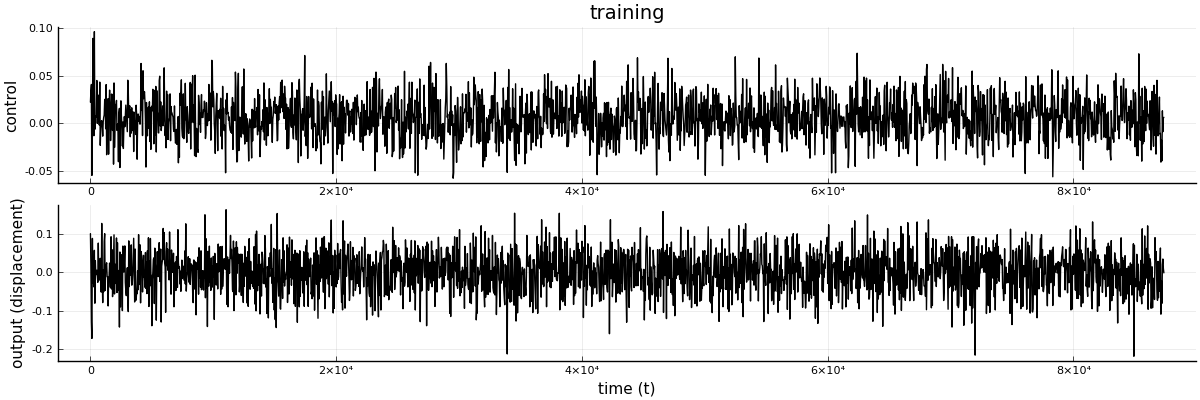

In [130]:
# Plot every n-th time-point to avoid figure size exploding
n = 40

if viz
    p1a = Plots.plot(1:n:T_, input_[1:n:end], color="black", label="", markersize=2, xlabel="", ylabel="control", size=(1200,400), title="training")    
    p1b = Plots.plot(1:n:T_, output_[1:n:end], color="black", label="", markersize=2, xlabel="time (t)", ylabel="output (displacement)", size=(1200,400))    
    p1 = plot(p1a, p1b, layout=(2,1))
#     Plots.savefig(p1, "viz/constant-amp-regime.png")
end

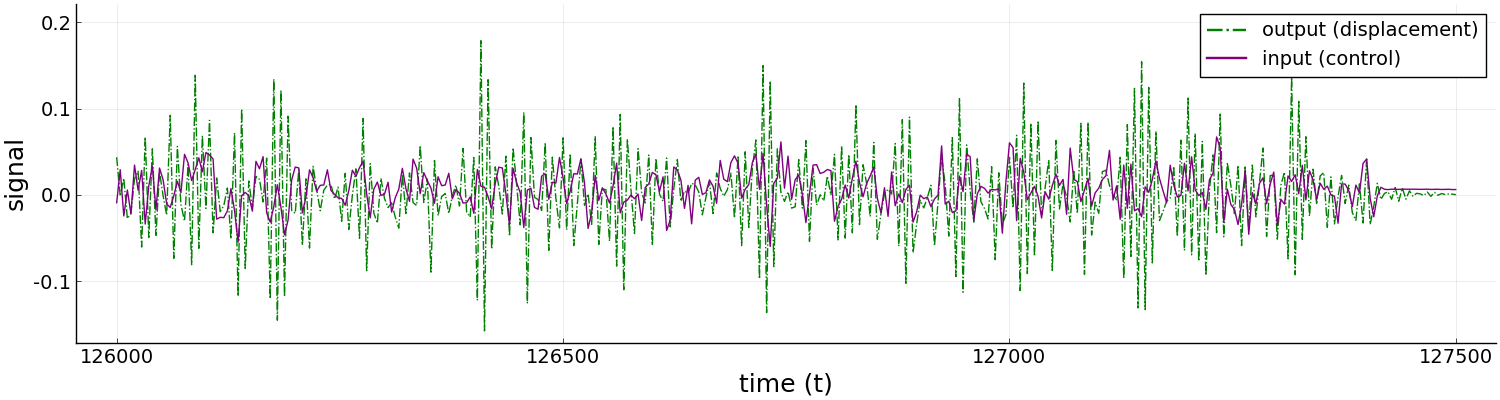

In [324]:
ss = 4
ix = 126000:ss:127500
p31 = Plots.plot(ix, output[ix], color="green", markersize=2, xlabel="time (t)", label="output (displacement)", linestyle=:dashdot)    
Plots.plot!(ix, input[ix], color="purple", markersize=2, xlabel="time (t)", label="input (control)", size=(1500,400), ylim=[-.16, .21], legend=:topright, tickfontsize=14, legendfontsize=14, ylabel="signal", guidefontsize=18)

In [325]:
Plots.savefig(p31, "viz/input-output_seq1.png")
Plots.savefig(p31, "viz/input-output_seq1.pdf")

## Estimating parameters via Bayesian filtering

Implementation with ForneyLab and AR node. The AR node is locally modified from the package LAR (LAR is in dev mode). It now contains an AutoregressiveControlNL node, where I can add a nonlinearity g as an argument.

In [135]:
using LinearAlgebra
using ForneyLab
using ForneyLab: unsafeMean, unsafeCov, unsafeVar, unsafePrecision
using LAR
using LAR.Node, LAR.Data
using ProgressMeter

In [136]:
using Zygote

function Jacobian(F, x)
    y = F(x)
    n = length(y)
    m = length(x)
    T = eltype(y)
    J = Array{T, 2}(undef, n, m)
    for i in 1:n
        J[i, :] .= gradient(x -> F(x)[i], x)[1]
    end
    return J
end;

In [137]:
# System identification graph
graph1 = FactorGraph()

# Static parameters
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(3,)), placeholder(:w_θ, dims=(3,3)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))
@RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV ξ ~ Gamma(placeholder(:a_ξ), placeholder(:b_ξ))

# Nonlinearity
g(x,θ) = θ[1]*x[1] + θ[2]*x[1]^3 + θ[3]*x[2]

# State prior
@RV z_t ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_t)

# Autoregressive node
@RV x_t ~ AutoregressiveControlNL(θ, z_t, η, placeholder(:u_t), γ, g=g, id=:x_t)

# Specify likelihood
@RV y_t ~ GaussianMeanPrecision(dot([1. , 0.], x_t), ξ, id=:y_t)

# Placeholder for observation
placeholder(y_t, :y_t)

# Draw time-slice subgraph
ForneyLab.draw(graph1)

# Inference algorithm
q1 = PosteriorFactorization(z_t, x_t, θ, η, γ, ξ, ids=[:z, :x, :θ, :η, :γ, :ξ])
algo1 = variationalAlgorithm(q1, free_energy=false)
source_code1 = algorithmSourceCode(algo1, free_energy=false)
eval(Meta.parse(source_code1));
# println(source_code)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 6787095077415388232 -->
 
 6787095077415388232 
 
 placeholder_y_t 
 
<!-- 18400773482773760466 -->
 
 18400773482773760466 
 
 𝒩 
 y_t 
 
<!-- 6787095077415388232--18400773482773760466 -->
 
 6787095077415388232--18400773482773760466 
 
 y_t 
 1 out 
 1 out 
 
<!-- 17374343918309910974 -->
 
 17374343918309910974 
 
 placeholder_w_z 
 
<!-- 8226826055026340128 -->
 
 8226826055026340128 
 
 dot 
 dotproduct_1 
 
<!-- 17374610556316765389 -->
 
 17374610556316765389 
 
 clamp_1 
 
<!-- 8226826055026340128--17374610556316765389 -->
 
 8226826055026340128--17374610556316765389 
 
 clamp_1 
 1 out 
 3 in2 
 
<!-- 16579444508806630992 -->
 
 16579444508806630992 
 
 ARCNL 
 x_t 
 
<!-- 8226826055026340128--16579444508806630992 -->
 
 8226826055026340128--16579444508806630992 
 
 x_t 
 1 y 
 2 in1 
 
<!-- 13972843319481091803 -->
 
 13972843319481091803 
 
 Gam 
 gamma_2 
 
<!-- 2128954615388994321 -->
 
 2128954615388994321 
 
 placeholder_a_ξ 
 
<!-- 13972843319481091803--2128954615388994321 -->
 
 13972843319481091803--2128954615388994321 
 
 a_ξ 
 1 out 
 2 a 
 
<!-- 9661311191372340011 -->
 
 9661311191372340011 
 
 placeholder_b_ξ 
 
<!-- 13972843319481091803--9661311191372340011 -->
 
 13972843319481091803--9661311191372340011 
 
 b_ξ 
 1 out 
 3 b 
 
<!-- 12405183549715267133 -->
 
 12405183549715267133 
 
 placeholder_b_γ 
 
<!-- 2033253366160360866 -->
 
 2033253366160360866 
 
 Gam 
 gamma_1 
 
<!-- 2033253366160360866--12405183549715267133 -->
 
 2033253366160360866--12405183549715267133 
 
 b_γ 
 1 out 
 3 b 
 
<!-- 16706416457678743437 -->
 
 16706416457678743437 
 
 placeholder_a_γ 
 
<!-- 2033253366160360866--16706416457678743437 -->
 
 2033253366160360866--16706416457678743437 
 
 a_γ 
 1 out 
 2 a 
 
<!-- 6037745484562676096 -->
 
 6037745484562676096 
 
 𝒩 
 z_t 
 
<!-- 6037745484562676096--17374343918309910974 -->
 
 6037745484562676096--17374343918309910974 
 
 w_z 
 1 out 
 3 w 
 
<!-- 845113390934107388 -->
 
 845113390934107388 
 
 placeholder_m_z 
 
<!-- 6037745484562676096--845113390934107388 -->
 
 6037745484562676096--845113390934107388 
 
 m_z 
 1 out 
 2 m 
 
<!-- 15961286470245074104 -->
 
 15961286470245074104 
 
 placeholder_m_θ 
 
<!-- 16579444508806630992--2033253366160360866 -->
 
 16579444508806630992--2033253366160360866 
 
 γ 
 1 out 
 6 γ 
 
<!-- 16579444508806630992--6037745484562676096 -->
 
 16579444508806630992--6037745484562676096 
 
 z_t 
 1 out 
 2 x 
 
<!-- 6216507690748533519 -->
 
 6216507690748533519 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 16579444508806630992--6216507690748533519 -->
 
 16579444508806630992--6216507690748533519 
 
 θ 
 1 out 
 3 θ 
 
<!-- 11860898381449484625 -->
 
 11860898381449484625 
 
 placeholder_u_t 
 
<!-- 16579444508806630992--11860898381449484625 -->
 
 16579444508806630992--11860898381449484625 
 
 u_t 
 1 out 
 5 u 
 
<!-- 5706385886346998115 -->
 
 5706385886346998115 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 16579444508806630992--5706385886346998115 -->
 
 16579444508806630992--5706385886346998115 
 
 η 
 1 out 
 4 η 
 
<!-- 18400773482773760466--8226826055026340128 -->
 
 18400773482773760466--8226826055026340128 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 18400773482773760466--13972843319481091803 -->
 
 18400773482773760466--13972843319481091803 
 
 ξ 
 1 out 
 3 w 
 
<!-- 6216507690748533519--15961286470245074104 -->
 
 6216507690748533519--15961286470245074104 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 6345762214461725063 -->
 
 6345762214461725063 
 
 placeholder_w_θ 
 
<!-- 6216507690748533519--6345762214461725063 -->
 
 6216507690748533519--6345762214461725063 
 
 w_θ 
 1 out 
 3 w 
 
<!-- 8461458941486213300 -->
 
 8461458941486213300 
 
 placeholder_m_η 
 
<!-- 5706385886346998115--8461458941486213300 -->
 

In [138]:
# Forecasting graph
graph2 = FactorGraph()

# State prior
@RV z_pred ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_t)

# Autoregressive node
@RV x_pred ~ AutoregressiveControlNL(placeholder(:θ, dims=(3,)), z_pred, placeholder(:η), placeholder(:u_t), placeholder(:γ), g=g, id=:x_t)

# Draw time-slice subgraph
ForneyLab.draw(graph2)

# Inference algorithm
q2 = PosteriorFactorization(z_pred, x_pred, ids=[:z_pred, :x_pred])
algo2 = variationalAlgorithm(q2, free_energy=false)
source_code2 = algorithmSourceCode(algo2, free_energy=false)
eval(Meta.parse(source_code2));
# println(source_code)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 3406053165878887246 -->
 
 3406053165878887246 
 
 𝒩 
 z_t 
 
<!-- 2517330218432387292 -->
 
 2517330218432387292 
 
 placeholder_m_z 
 
<!-- 3406053165878887246--2517330218432387292 -->
 
 3406053165878887246--2517330218432387292 
 
 m_z 
 1 out 
 2 m 
 
<!-- 3042689512369669289 -->
 
 3042689512369669289 
 
 placeholder_w_z 
 
<!-- 3406053165878887246--3042689512369669289 -->
 
 3406053165878887246--3042689512369669289 
 
 w_z 
 1 out 
 3 w 
 
<!-- 1422752779572797333 -->
 
 1422752779572797333 
 
 placeholder_η 
 
<!-- 6889680066794484434 -->
 
 6889680066794484434 
 
 placeholder_u_t 
 
<!-- 6633562905445149175 -->
 
 6633562905445149175 
 
 placeholder_γ 
 
<!-- 12555288359230755062 -->
 
 12555288359230755062 
 
 ARCNL 
 x_t 
 
<!-- 12555288359230755062--3406053165878887246 -->
 
 12555288359230755062--3406053165878887246 
 
 z_pred 
 1 out 
 2 x 
 
<!-- 12555288359230755062--1422752779572797333 -->
 
 12555288359230755062--1422752779572797333 
 
 η 
 1 out 
 4 η 
 
<!-- 12555288359230755062--6889680066794484434 -->
 
 12555288359230755062--6889680066794484434 
 
 u_t 
 1 out 
 5 u 
 
<!-- 12555288359230755062--6633562905445149175 -->
 
 12555288359230755062--6633562905445149175 
 
 γ 
 1 out 
 6 γ 
 
<!-- 12154192208903243038 -->
 
 12154192208903243038 
 
 placeholder_θ 
 
<!-- 12555288359230755062--12154192208903243038 -->
 
 12555288359230755062--12154192208903243038 
 
 θ 
 1 out 
 3 θ 
 
<!-- 143300443307404311882 -->
 
 143300443307404311882 
 
<!-- 143300443307404311882--12555288359230755062 -->
 
 143300443307404311882--12555288359230755062 
 
 x_pred 
 1 y

### Infer parameters and forecast several steps ahead

In [139]:
# Number of steps ahead
TT = 10

# Inference parameters
num_iterations = 10

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_x = (zeros(2,T_ - TT), repeat(.1 .*float(eye(2)), outer=(1,1,T_ - TT)))
params_θ = (ones(3,T_ - TT), repeat(.1 .*float(eye(3)), outer=(1,1,T_ - TT)))
params_η = (ones(1,T_ - TT), .1*ones(1,T_ - TT))
params_γ = (1e3*ones(1,T_ - TT), 1e1*ones(1,T_ - TT))
params_ξ = (1e8*ones(1,T_ - TT), 1e3*ones(1,T_ - TT))

# Initialize coefficient vector arrays
params_ϕ = (zeros(5,T_ - TT), zeros(5,5,T_ - TT))
params_ψ = (zeros(5,T_ - TT), zeros(5,5,T_ - TT))

# Initialize future state arrays
params_xpred_nar = (zeros(2, T_ - TT, TT+1), repeat(.1 .*float(eye(2)), outer=(1,1,T_ - TT, TT+1)))
pred_diff_nar = zeros(T_ - TT, TT)
pred_pwerr_nar = zeros(T_ - TT, TT)

# Transformations between physical and substituted variables: ψ = G(ϕ) => ϕ = G_inv(ψ)
G(ϕ) = [(2*ϕ[1] + ϕ[2] - ϕ[3])/(ϕ[1]+ϕ[2]), -ϕ[4]/(ϕ[1]+ϕ[2]), -ϕ[1]/(ϕ[1]+ϕ[2]), 1/(ϕ[1]+ϕ[2]), ϕ[5]*(ϕ[1]+ϕ[2])^2]
G_inv(ψ) = [-ψ[3]/ψ[4], (1+ψ[3])/ψ[4], (1 - ψ[1] - ψ[3])/ψ[4], -ψ[2]/ψ[4], ψ[5]*ψ[4]^2]

# Start progress bar
p = Progress(T_ - TT, 1, "At time ")

# Perform inference at each time-step
for t = 2:(T_ - TT)

    # Update progress bar
    update!(p, t)
    
    "Filtering"

    # Initialize marginals
    marginals[:x_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t-1], w=params_x[2][:,:,t-1])
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t-1], w=params_x[2][:,:,t-1])
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t-1], w=params_θ[2][:,:,t-1])
    marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_η[1][1,t-1], w=params_η[2][1,t-1])
    marginals[:γ] = ProbabilityDistribution(Univariate, Gamma, a=params_γ[1][1,t-1], b=params_γ[2][1,t-1])
    marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=params_ξ[1][1,t-1], b=params_ξ[2][1,t-1])
    
    data = Dict(:y_t => output_[t],
                :u_t => input_[t],
                :m_z => params_x[1][:,t-1],
                :w_z => params_x[2][:,:,t-1],
                :m_θ => params_θ[1][:,t-1],
                :w_θ => params_θ[2][:,:,t-1],
                :m_η => params_η[1][1,t-1],
                :w_η => params_η[2][1,t-1],
                :a_γ => params_γ[1][1,t-1],
                :b_γ => params_γ[2][1,t-1],
                :a_ξ => params_ξ[1][1,t-1],
                :b_ξ => params_ξ[2][1,t-1])

    # Iterate variational parameter updates
    for i = 1:num_iterations

        stepx!(data, marginals)
        stepθ!(data, marginals)
        stepη!(data, marginals)
        stepγ!(data, marginals)
        stepξ!(data, marginals)
    #         stepz!(data, marginals)
    end

    # Store current parameterizations of marginals
    params_x[1][:,t] = unsafeMean(marginals[:x_t])
    params_x[2][:,:,t] = marginals[:x_t].params[:w]
    params_θ[1][:,t] = unsafeMean(marginals[:θ])
    params_θ[2][:,:,t] = marginals[:θ].params[:w]
    params_η[1][1,t] = unsafeMean(marginals[:η])
    params_η[2][1,t] = marginals[:η].params[:w]
    params_γ[1][1,t] = marginals[:γ].params[:a]
    params_γ[2][1,t] = marginals[:γ].params[:b]
    params_ξ[1][1,t] = marginals[:ξ].params[:a]
    params_ξ[2][1,t] = marginals[:ξ].params[:b]
    
    "Map substituted to physical variables via first-order Taylor"
    
    # Approximate gamma with log-normal via moment-matching
    Eγ = unsafeMean(marginals[:γ])
    Vγ = unsafeVar(marginals[:γ])
    m_γ = log(Eγ^2/sqrt(Vγ + Eγ^2))
    v_γ = log(Vγ/Eγ^2 + 1)

    # Construct vector of parameter estimates ψ
    m_ψ = [unsafeMean(marginals[:θ])[1], unsafeMean(marginals[:θ])[2], unsafeMean(marginals[:θ])[3], unsafeMean(marginals[:η])[1], m_γ]
    V_ψ = [unsafeCov(marginals[:θ]) zeros(3,2); zeros(2,3) [unsafeCov(marginals[:η])[1,1] 0;0 v_γ]]
    
    # Store psi
    params_ψ[1][:,t] = m_ψ
    params_ψ[2][:,:,t] = V_ψ
    
    # Compute Jacobian of transformation 
    J_ψ = Jacobian(G_inv, m_ψ)
    
    # Compute moments of transformed Gaussian using first-order Taylor approx
    m_ϕ = G_inv(m_ψ)
    V_ϕ = J_ψ*V_ψ*J_ψ'
    
    # Store phi
    params_ϕ[1][:,t] = m_ϕ
    params_ϕ[2][:,:,t] = V_ϕ
    
    "Forecast several steps ahead"
    
    if T_ > 2
    
        params_xpred_nar[1][:,t,1] = params_x[1][:,t]
        params_xpred_nar[2][:,:,t,1] = params_x[2][:,:,t]

        for tt = 1:TT

            # Initialize marginals
            marginals[:x_pred] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_xpred_nar[1][:,t,tt], w=params_xpred_nar[2][:,:,t,tt])
            marginals[:z_pred] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_xpred_nar[1][:,t,tt], w=params_xpred_nar[2][:,:,t,tt])

            data = Dict(:u_t => input_[t+tt],
                        :m_z => params_xpred_nar[1][:,t,tt],
                        :w_z => params_xpred_nar[2][:,:,t,tt],
                        :θ => params_θ[1][:,t],
                        :η => params_η[1][t],
                        :γ => params_γ[1][t]/params_γ[2][t])

            # Iterate variational parameter updates
            for i = 1:num_iterations
                stepx_pred!(data, marginals)
        #             stepz_pred!(data, marginals)
            end

            # Store current parameterizations of marginals
            params_xpred_nar[1][:,t,tt+1] = unsafeMean(marginals[:x_pred])
            params_xpred_nar[2][:,:,t,tt+1] = marginals[:x_pred].params[:w]

        end

        # Evaluate prediction error for forecast
        pred_diff_nar[t,:] = (params_xpred_nar[1][1,t,2:end] .- output_[t+1:t+TT])
        pred_pwerr_nar[t,:] = params_xpred_nar[2][1,1,t,2:end].*(params_xpred_nar[1][1,t,2:end] .- output_[t+1:t+TT]).^2

    end

end

At time 100%|███████████████████████████████████████████| Time: 0:04:11


### Visualize results

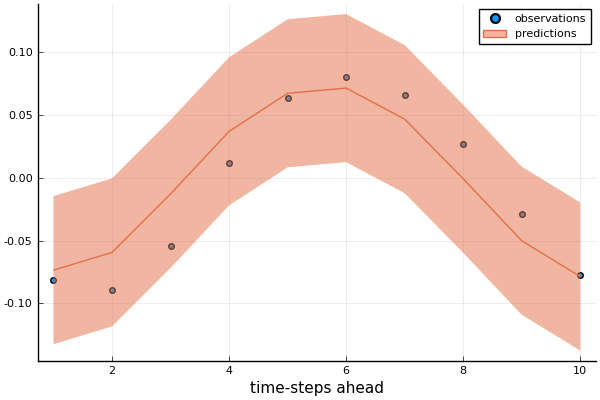

In [227]:
# Pick a time-point and visualize forecasting
t = 87200

# Mean and std dev of predictions
xpred_nar_mean = params_xpred_nar[1][1,t,2:TT+1]
xpred_nar_std = sqrt.(inv.(params_xpred_nar[2][1,1,t,2:TT+1])) 


scatter(output_[t+1:t+TT], label="observations", xlabel="time-steps ahead")
plot!(xpred_nar_mean, ribbon=[xpred_nar_std, xpred_nar_std], label="predictions")

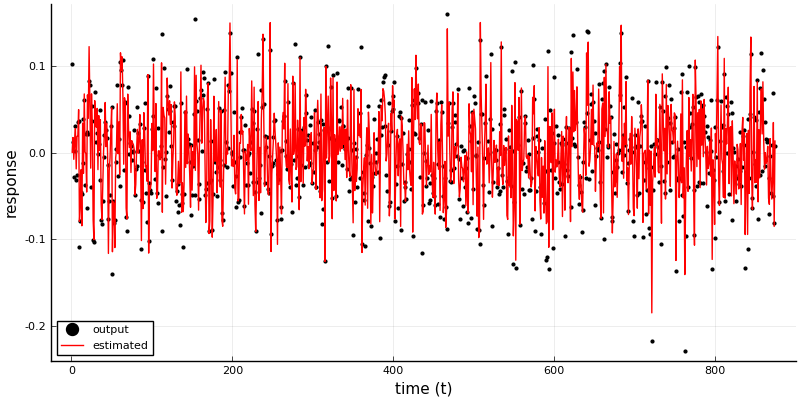

In [221]:
# Pick a number of steps ahead
tt = 9

# Extract mean of state marginals
estimated_states_nar = params_xpred_nar[1][1,:,1+tt]

# Plot every n-th time-point to avoid figure size exploding
n = 100

p23 = Plots.scatter(output_[1:n:end], color="black", label="output", markersize=2, size=(800,400), xlabel="time (t)", ylabel="response", legend=:bottomleft)
Plots.plot!(estimated_states_nar[1:n:end], color="red", linewidth=1, label="estimated")

In [144]:
Plots.savefig(p23, "viz/forecasted-states-nar_"*string(tt)*"stepahead.png")

## Baselines - linear

We can ignore the nonlinear component. This will be a good baseline.

In [146]:
# System identification graph
graph3 = FactorGraph()

# Static parameters
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(2,)), placeholder(:w_θ, dims=(2,2)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))
@RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV ξ ~ Gamma(placeholder(:a_ξ), placeholder(:b_ξ))

# State prior
@RV z_lar ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_t)

# Autoregressive node
@RV x_lar ~ AutoregressiveControl(θ, z_lar, η, placeholder(:u_t), γ, id=:x_t)

# Specify likelihood
@RV y_t ~ GaussianMeanPrecision(dot([1. , 0.], x_lar), ξ, id=:y_t)

# Placeholder for observation
placeholder(y_t, :y_t)

# Draw time-slice subgraph
ForneyLab.draw(graph1)

# Inference algorithm
q1 = PosteriorFactorization(z_lar, x_lar, θ, η, γ, ξ, ids=[:z_lar, :x_lar, :θ, :η, :γ, :ξ])
algo1 = variationalAlgorithm(q1, free_energy=false)
source_code1 = algorithmSourceCode(algo1, free_energy=false)
eval(Meta.parse(source_code1));
# println(source_code)

# Forecasting graph
graph4= FactorGraph()

# State prior
@RV z_pred_lar ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_t)

# Autoregressive node
@RV x_pred_lar ~ AutoregressiveControl(placeholder(:θ, dims=(2,)), z_pred_lar, placeholder(:η), placeholder(:u_t), placeholder(:γ), id=:x_t)

# Draw time-slice subgraph
ForneyLab.draw(graph4)

# Inference algorithm
q4 = PosteriorFactorization(z_pred_lar, x_pred_lar, ids=[:z_pred_lar, :x_pred_lar])
algo4 = variationalAlgorithm(q4, free_energy=false)
source_code4 = algorithmSourceCode(algo4, free_energy=false)
eval(Meta.parse(source_code4));
# println(source_code4)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 6787095077415388232 -->
 
 6787095077415388232 
 
 placeholder_y_t 
 
<!-- 18400773482773760466 -->
 
 18400773482773760466 
 
 𝒩 
 y_t 
 
<!-- 6787095077415388232--18400773482773760466 -->
 
 6787095077415388232--18400773482773760466 
 
 y_t 
 1 out 
 1 out 
 
<!-- 17374343918309910974 -->
 
 17374343918309910974 
 
 placeholder_w_z 
 
<!-- 8226826055026340128 -->
 
 8226826055026340128 
 
 dot 
 dotproduct_1 
 
<!-- 17374610556316765389 -->
 
 17374610556316765389 
 
 clamp_1 
 
<!-- 8226826055026340128--17374610556316765389 -->
 
 8226826055026340128--17374610556316765389 
 
 clamp_1 
 1 out 
 3 in2 
 
<!-- 16579444508806630992 -->
 
 16579444508806630992 
 
 ARCNL 
 x_t 
 
<!-- 8226826055026340128--16579444508806630992 -->
 
 8226826055026340128--16579444508806630992 
 
 x_t 
 1 y 
 2 in1 
 
<!-- 13972843319481091803 -->
 
 13972843319481091803 
 
 Gam 
 gamma_2 
 
<!-- 2128954615388994321 -->
 
 2128954615388994321 
 
 placeholder_a_ξ 
 
<!-- 13972843319481091803--2128954615388994321 -->
 
 13972843319481091803--2128954615388994321 
 
 a_ξ 
 1 out 
 2 a 
 
<!-- 9661311191372340011 -->
 
 9661311191372340011 
 
 placeholder_b_ξ 
 
<!-- 13972843319481091803--9661311191372340011 -->
 
 13972843319481091803--9661311191372340011 
 
 b_ξ 
 1 out 
 3 b 
 
<!-- 12405183549715267133 -->
 
 12405183549715267133 
 
 placeholder_b_γ 
 
<!-- 2033253366160360866 -->
 
 2033253366160360866 
 
 Gam 
 gamma_1 
 
<!-- 2033253366160360866--12405183549715267133 -->
 
 2033253366160360866--12405183549715267133 
 
 b_γ 
 1 out 
 3 b 
 
<!-- 16706416457678743437 -->
 
 16706416457678743437 
 
 placeholder_a_γ 
 
<!-- 2033253366160360866--16706416457678743437 -->
 
 2033253366160360866--16706416457678743437 
 
 a_γ 
 1 out 
 2 a 
 
<!-- 6037745484562676096 -->
 
 6037745484562676096 
 
 𝒩 
 z_t 
 
<!-- 6037745484562676096--17374343918309910974 -->
 
 6037745484562676096--17374343918309910974 
 
 w_z 
 1 out 
 3 w 
 
<!-- 845113390934107388 -->
 
 845113390934107388 
 
 placeholder_m_z 
 
<!-- 6037745484562676096--845113390934107388 -->
 
 6037745484562676096--845113390934107388 
 
 m_z 
 1 out 
 2 m 
 
<!-- 15961286470245074104 -->
 
 15961286470245074104 
 
 placeholder_m_θ 
 
<!-- 16579444508806630992--2033253366160360866 -->
 
 16579444508806630992--2033253366160360866 
 
 γ 
 1 out 
 6 γ 
 
<!-- 16579444508806630992--6037745484562676096 -->
 
 16579444508806630992--6037745484562676096 
 
 z_t 
 1 out 
 2 x 
 
<!-- 6216507690748533519 -->
 
 6216507690748533519 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 16579444508806630992--6216507690748533519 -->
 
 16579444508806630992--6216507690748533519 
 
 θ 
 1 out 
 3 θ 
 
<!-- 11860898381449484625 -->
 
 11860898381449484625 
 
 placeholder_u_t 
 
<!-- 16579444508806630992--11860898381449484625 -->
 
 16579444508806630992--11860898381449484625 
 
 u_t 
 1 out 
 5 u 
 
<!-- 5706385886346998115 -->
 
 5706385886346998115 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 16579444508806630992--5706385886346998115 -->
 
 16579444508806630992--5706385886346998115 
 
 η 
 1 out 
 4 η 
 
<!-- 18400773482773760466--8226826055026340128 -->
 
 18400773482773760466--8226826055026340128 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 18400773482773760466--13972843319481091803 -->
 
 18400773482773760466--13972843319481091803 
 
 ξ 
 1 out 
 3 w 
 
<!-- 6216507690748533519--15961286470245074104 -->
 
 6216507690748533519--15961286470245074104 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 6345762214461725063 -->
 
 6345762214461725063 
 
 placeholder_w_θ 
 
<!-- 6216507690748533519--6345762214461725063 -->
 
 6216507690748533519--6345762214461725063 
 
 w_θ 
 1 out 
 3 w 
 
<!-- 8461458941486213300 -->
 
 8461458941486213300 
 
 placeholder_m_η 
 
<!-- 5706385886346998115--8461458941486213300 -->
 

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 8402986123202768596 -->
 
 8402986123202768596 
 
 placeholder_u_t 
 
<!-- 490097078851685451 -->
 
 490097078851685451 
 
 placeholder_m_z 
 
<!-- 11465180113588311808 -->
 
 11465180113588311808 
 
 ARC 
 x_t 
 
<!-- 11465180113588311808--8402986123202768596 -->
 
 11465180113588311808--8402986123202768596 
 
 u_t 
 1 out 
 5 u 
 
<!-- 10746852184774144071 -->
 
 10746852184774144071 
 
 placeholder_θ 
 
<!-- 11465180113588311808--10746852184774144071 -->
 
 11465180113588311808--10746852184774144071 
 
 θ 
 1 out 
 3 θ 
 
<!-- 10660028370725567650 -->
 
 10660028370725567650 
 
 placeholder_γ 
 
<!-- 11465180113588311808--10660028370725567650 -->
 
 11465180113588311808--10660028370725567650 
 
 γ 
 1 out 
 6 γ 
 
<!-- 14407455892351090093 -->
 
 14407455892351090093 
 
 placeholder_η 
 
<!-- 11465180113588311808--14407455892351090093 -->
 
 11465180113588311808--14407455892351090093 
 
 η 
 1 out 
 4 η 
 
<!-- 3282324751467254380 -->
 
 3282324751467254380 
 
 𝒩 
 z_t 
 
<!-- 11465180113588311808--3282324751467254380 -->
 
 11465180113588311808--3282324751467254380 
 
 z_pred_lar 
 1 out 
 2 x 
 
<!-- 11201509928222470309 -->
 
 11201509928222470309 
 
 placeholder_w_z 
 
<!-- 3282324751467254380--490097078851685451 -->
 
 3282324751467254380--490097078851685451 
 
 m_z 
 1 out 
 2 m 
 
<!-- 3282324751467254380--11201509928222470309 -->
 
 3282324751467254380--11201509928222470309 
 
 w_z 
 1 out 
 3 w 
 
<!-- 9140325902578759642 -->
 
 9140325902578759642 
 
<!-- 9140325902578759642--11465180113588311808 -->
 
 9140325902578759642--11465180113588311808 
 
 x_pred_lar 
 1 y

In [147]:
# Number of steps ahead
TT = 10

# Inference parameters
num_iterations = 10

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_x = (zeros(2,T_ - TT), repeat(.1 .*float(eye(2)), outer=(1,1,T_ - TT)))
params_θ = (ones(2,T_ - TT), repeat(.1 .*float(eye(2)), outer=(1,1,T_ - TT)))
params_η = (ones(1,T_ - TT), .1*ones(1,T_ - TT))
params_γ = (1e3*ones(1,T_ - TT), 1e1*ones(1,T_ - TT))
params_ξ = (1e8*ones(1,T_ - TT), 1e3*ones(1,T_ - TT))

# Initialize future state arrays
params_xpred_lar = (zeros(2, T_ - TT, TT+1), repeat(.1 .*float(eye(2)), outer=(1,1,T_ - TT, TT+1)))
pred_diff_lar = zeros(T_ - TT, TT)
pred_pwerr_lar = zeros(T_ - TT, TT)

# Start progress bar
p = Progress(T_ - TT, 1, "At time ")

# Perform inference at each time-step
for t = 2:(T_ - TT)

    # Update progress bar
    update!(p, t)
    
    "Filtering"

    # Initialize marginals
    marginals[:x_lar] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t-1], w=params_x[2][:,:,t-1])
    marginals[:z_lar] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t-1], w=params_x[2][:,:,t-1])
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t-1], w=params_θ[2][:,:,t-1])
    marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_η[1][1,t-1], w=params_η[2][1,t-1])
    marginals[:γ] = ProbabilityDistribution(Univariate, Gamma, a=params_γ[1][1,t-1], b=params_γ[2][1,t-1])
    marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=params_ξ[1][1,t-1], b=params_ξ[2][1,t-1])
    
    data = Dict(:y_t => output_[t],
                :u_t => input_[t],
                :m_z => params_x[1][:,t-1],
                :w_z => params_x[2][:,:,t-1],
                :m_θ => params_θ[1][:,t-1],
                :w_θ => params_θ[2][:,:,t-1],
                :m_η => params_η[1][1,t-1],
                :w_η => params_η[2][1,t-1],
                :a_γ => params_γ[1][1,t-1],
                :b_γ => params_γ[2][1,t-1],
                :a_ξ => params_ξ[1][1,t-1],
                :b_ξ => params_ξ[2][1,t-1])

    # Iterate variational parameter updates
    for i = 1:num_iterations

        stepx_lar!(data, marginals)
        stepθ!(data, marginals)
        stepη!(data, marginals)
        stepγ!(data, marginals)
        stepξ!(data, marginals)
    #         stepz_lar!(data, marginals)
    end

    # Store current parameterizations of marginals
    params_x[1][:,t] = unsafeMean(marginals[:x_lar])
    params_x[2][:,:,t] = marginals[:x_lar].params[:w]
    params_θ[1][:,t] = unsafeMean(marginals[:θ])
    params_θ[2][:,:,t] = marginals[:θ].params[:w]
    params_η[1][1,t] = unsafeMean(marginals[:η])
    params_η[2][1,t] = marginals[:η].params[:w]
    params_γ[1][1,t] = marginals[:γ].params[:a]
    params_γ[2][1,t] = marginals[:γ].params[:b]
    params_ξ[1][1,t] = marginals[:ξ].params[:a]
    params_ξ[2][1,t] = marginals[:ξ].params[:b]
    
    "Forecast several steps ahead"
    
    if T_ > 2
    
        params_xpred_lar[1][:,t,1] = params_x[1][:,t]
        params_xpred_lar[2][:,:,t,1] = params_x[2][:,:,t]

        for tt = 1:TT

            # Initialize marginals
            marginals[:x_pred_lar] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_xpred_lar[1][:,t,tt], w=params_xpred_lar[2][:,:,t,tt])
            marginals[:z_pred_lar] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_xpred_lar[1][:,t,tt], w=params_xpred_lar[2][:,:,t,tt])

            data = Dict(:u_t => input_[t+tt],
                        :m_z => params_xpred_lar[1][:,t,tt],
                        :w_z => params_xpred_lar[2][:,:,t,tt],
                        :θ => params_θ[1][:,t],
                        :η => params_η[1][t],
                        :γ => params_γ[1][t]/params_γ[2][t])

            # Iterate variational parameter updates
            for i = 1:num_iterations
                stepx_pred_lar!(data, marginals)
        #             stepz_pred_lar!(data, marginals)
            end

            # Store current parameterizations of marginals
            params_xpred_lar[1][:,t,tt+1] = unsafeMean(marginals[:x_pred_lar])
            params_xpred_lar[2][:,:,t,tt+1] = marginals[:x_pred_lar].params[:w]

        end

        # Evaluate prediction error for forecast
        pred_diff_lar[t,:] = (params_xpred_lar[1][1,t,2:end] .- output_[t+1:t+TT])
        pred_pwerr_lar[t,:] = params_xpred_lar[2][1,1,t,2:end].*(params_xpred_lar[1][1,t,2:end] .- output_[t+1:t+TT]).^2

    end

end

At time 100%|███████████████████████████████████████████| Time: 0:03:55


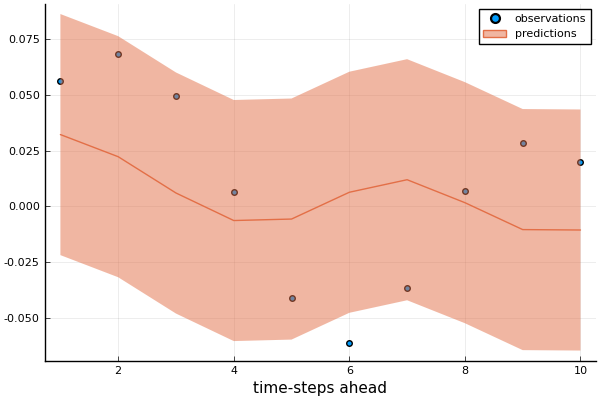

In [148]:
# Pick a time-point and visualize forecasting
t = 9000

# Mean and std dev of predictions
xpred_lar_mean = params_xpred_lar[1][1,t,2:TT+1]
xpred_lar_std = sqrt.(inv.(params_xpred_lar[2][1,1,t,2:TT+1])) 


scatter(output_[t+1:t+TT], label="observations", xlabel="time-steps ahead")
plot!(xpred_lar_mean, ribbon=[xpred_lar_std, xpred_lar_std], label="predictions")

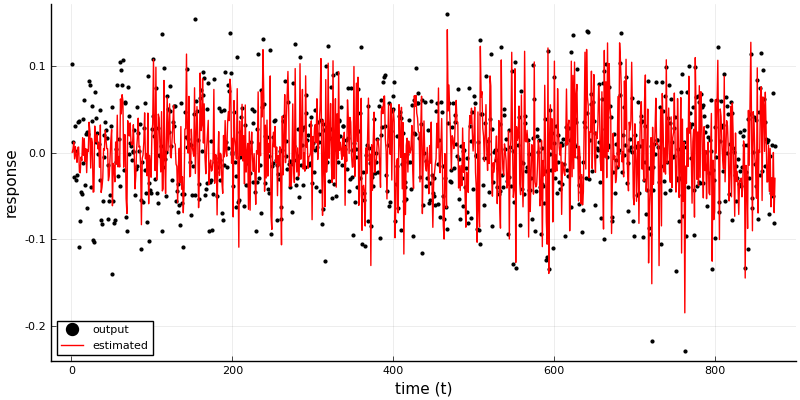

In [151]:
# Pick a number of steps ahead
tt = 2

# Extract mean of state marginals
estimated_states_lar = params_xpred_lar[1][1,:,tt]

# Plot every n-th time-point to avoid figure size exploding
n = 100

p23 = Plots.scatter(output_[1:n:end], color="black", label="output", markersize=2, size=(800,400), xlabel="time (t)", ylabel="response", legend=:bottomleft)
Plots.plot!(estimated_states_lar[1:n:end], color="red", linewidth=1, label="estimated")

In [152]:
Plots.savefig(p23, "viz/forecasted-states-lar_"*string(tt)*"stepahead.png")

## Baseline - scaled control

In [154]:
# # System identification graph
# graph5 = FactorGraph()

# # Static parameters
# θ = [1.0, 0.0]
# η = 1.0
# γ = params_γ[1][end]./params_γ[2][end]
# ξ = params_ξ[1][end]./params_ξ[2][end]

# # State prior
# @RV z_rw ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_t)

# # Autoregressive node
# @RV x_rw ~ AutoregressiveControl(θ, z_rw, η, placeholder(:u_t), γ, id=:x_t)

# # Specify likelihood
# @RV y_t ~ GaussianMeanPrecision(dot([1. , 0.], x_rw), ξ, id=:y_t)

# # Placeholder for observation
# placeholder(y_t, :y_t)

# # Draw time-slice subgraph
# ForneyLab.draw(graph5)

# # Inference algorithm
# q5 = PosteriorFactorization(z_rw, x_rw, ids=[:z_rw, :x_rw])
# algo5 = variationalAlgorithm(q5, free_energy=false)
# source_code5 = algorithmSourceCode(algo5, free_energy=false)
# eval(Meta.parse(source_code5));
# # println(source_code5)

# # Forecasting graph
# graph6 = FactorGraph()

# # State prior
# @RV z_pred_rw ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_t)

# # Autoregressive node
# @RV x_pred_rw ~ AutoregressiveControl(θ, z_pred_rw, η, placeholder(:u_t), γ, id=:x_t)

# # Draw time-slice subgraph
# ForneyLab.draw(graph6)

# # Inference algorithm
# q6 = PosteriorFactorization(z_pred_rw, x_pred_rw, ids=[:z_pred_rw, :x_pred_rw])
# algo6 = variationalAlgorithm(q6, free_energy=false)
# source_code6 = algorithmSourceCode(algo6, free_energy=false)
# eval(Meta.parse(source_code6));
# # println(source_code6)

## Baselines - random walk

In [155]:
# System identification graph
graph5 = FactorGraph()

# Static parameters
θ = [1.0, 0.0]
η = 1.0
γ = params_γ[1][end]./params_γ[2][end]
ξ = params_ξ[1][end]./params_ξ[2][end]

# State prior
@RV z_rw ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_t)

# Autoregressive node
@RV x_rw ~ AutoregressiveControl(θ, z_rw, η, placeholder(:u_t), γ, id=:x_t)

# Specify likelihood
@RV y_t ~ GaussianMeanPrecision(dot([1. , 0.], x_rw), ξ, id=:y_t)

# Placeholder for observation
placeholder(y_t, :y_t)

# Draw time-slice subgraph
ForneyLab.draw(graph5)

# Inference algorithm
q5 = PosteriorFactorization(z_rw, x_rw, ids=[:z_rw, :x_rw])
algo5 = variationalAlgorithm(q5, free_energy=false)
source_code5 = algorithmSourceCode(algo5, free_energy=false)
eval(Meta.parse(source_code5));
# println(source_code5)

# Forecasting graph
graph6 = FactorGraph()

# State prior
@RV z_pred_rw ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_t)

# Autoregressive node
@RV x_pred_rw ~ AutoregressiveControl(θ, z_pred_rw, η, placeholder(:u_t), γ, id=:x_t)

# Draw time-slice subgraph
ForneyLab.draw(graph6)

# Inference algorithm
q6 = PosteriorFactorization(z_pred_rw, x_pred_rw, ids=[:z_pred_rw, :x_pred_rw])
algo6 = variationalAlgorithm(q6, free_energy=false)
source_code6 = algorithmSourceCode(algo6, free_energy=false)
eval(Meta.parse(source_code6));
# println(source_code6)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 13381144686274308824 -->
 
 13381144686274308824 
 
 placeholder_u_t 
 
<!-- 4537449349848134635 -->
 
 4537449349848134635 
 
 placeholder_m_z 
 
<!-- 541874590979742966 -->
 
 541874590979742966 
 
 ARC 
 x_t 
 
<!-- 541874590979742966--13381144686274308824 -->
 
 541874590979742966--13381144686274308824 
 
 u_t 
 1 out 
 5 u 
 
<!-- 7004454177114195298 -->
 
 7004454177114195298 
 
 𝒩 
 z_t 
 
<!-- 541874590979742966--7004454177114195298 -->
 
 541874590979742966--7004454177114195298 
 
 z_rw 
 1 out 
 2 x 
 
<!-- 7993730955418096352 -->
 
 7993730955418096352 
 
 clamp_3 
 
<!-- 541874590979742966--7993730955418096352 -->
 
 541874590979742966--7993730955418096352 
 
 clamp_3 
 1 out 
 6 γ 
 
<!-- 14167693936022906896 -->
 
 14167693936022906896 
 
 clamp_2 
 
<!-- 541874590979742966--14167693936022906896 -->
 
 541874590979742966--14167693936022906896 
 
 clamp_2 
 1 out 
 4 η 
 
<!-- 10086346785880700041 -->
 
 10086346785880700041 
 
 clamp_1 
 
<!-- 541874590979742966--10086346785880700041 -->
 
 541874590979742966--10086346785880700041 
 
 clamp_1 
 1 out 
 3 θ 
 
<!-- 13695967197959913740 -->
 
 13695967197959913740 
 
 placeholder_y_t 
 
<!-- 16605673157376228962 -->
 
 16605673157376228962 
 
 𝒩 
 y_t 
 
<!-- 13695967197959913740--16605673157376228962 -->
 
 13695967197959913740--16605673157376228962 
 
 y_t 
 1 out 
 1 out 
 
<!-- 7004454177114195298--4537449349848134635 -->
 
 7004454177114195298--4537449349848134635 
 
 m_z 
 1 out 
 2 m 
 
<!-- 16648974650208940971 -->
 
 16648974650208940971 
 
 placeholder_w_z 
 
<!-- 7004454177114195298--16648974650208940971 -->
 
 7004454177114195298--16648974650208940971 
 
 w_z 
 1 out 
 3 w 
 
<!-- 18170040467258725885 -->
 
 18170040467258725885 
 
 dot 
 dotproduct_1 
 
<!-- 18170040467258725885--541874590979742966 -->
 
 18170040467258725885--541874590979742966 
 
 x_rw 
 1 y 
 2 in1 
 
<!-- 8395104971638752569 -->
 
 8395104971638752569 
 
 clamp_4 
 
<!-- 18170040467258725885--8395104971638752569 -->
 
 18170040467258725885--8395104971638752569 
 
 clamp_4 
 1 out 
 3 in2 
 
<!-- 16605673157376228962--18170040467258725885 -->
 
 16605673157376228962--18170040467258725885 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 12840684429044111005 -->
 
 12840684429044111005 
 
 clamp_5 
 
<!-- 16605673157376228962--12840684429044111005 -->
 
 16605673157376228962--12840684429044111005 
 
 clamp_5 
 1 out 
 3 w

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 2222384740067432973 -->
 
 2222384740067432973 
 
 ARC 
 x_t 
 
<!-- 6391899330824912228 -->
 
 6391899330824912228 
 
 clamp_3 
 
<!-- 2222384740067432973--6391899330824912228 -->
 
 2222384740067432973--6391899330824912228 
 
 clamp_3 
 1 out 
 6 γ 
 
<!-- 17943776932098840112 -->
 
 17943776932098840112 
 
 𝒩 
 z_t 
 
<!-- 2222384740067432973--17943776932098840112 -->
 
 2222384740067432973--17943776932098840112 
 
 z_pred_rw 
 1 out 
 2 x 
 
<!-- 3741573907146111172 -->
 
 3741573907146111172 
 
 clamp_2 
 
<!-- 2222384740067432973--3741573907146111172 -->
 
 2222384740067432973--3741573907146111172 
 
 clamp_2 
 1 out 
 4 η 
 
<!-- 13341722888668288315 -->
 
 13341722888668288315 
 
 clamp_1 
 
<!-- 2222384740067432973--13341722888668288315 -->
 
 2222384740067432973--13341722888668288315 
 
 clamp_1 
 1 out 
 3 θ 
 
<!-- 15756390764592680418 -->
 
 15756390764592680418 
 
 placeholder_u_t 
 
<!-- 2222384740067432973--15756390764592680418 -->
 
 2222384740067432973--15756390764592680418 
 
 u_t 
 1 out 
 5 u 
 
<!-- 6311266364244059977 -->
 
 6311266364244059977 
 
 placeholder_w_z 
 
<!-- 17943776932098840112--6311266364244059977 -->
 
 17943776932098840112--6311266364244059977 
 
 w_z 
 1 out 
 3 w 
 
<!-- 9265681700323839429 -->
 
 9265681700323839429 
 
 placeholder_m_z 
 
<!-- 17943776932098840112--9265681700323839429 -->
 
 17943776932098840112--9265681700323839429 
 
 m_z 
 1 out 
 2 m 
 
<!-- 135146317633282439722 -->
 
 135146317633282439722 
 
<!-- 135146317633282439722--2222384740067432973 -->
 
 135146317633282439722--2222384740067432973 
 
 x_pred_rw 
 1 y

In [156]:
# Number of steps ahead
TT = 10

# Inference parameters
num_iterations = 10

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_x = (zeros(2,T_ - TT), repeat(.1 .*float(eye(2)), outer=(1,1,T_ - TT)))

# Initialize future state arrays
params_xpred_rw = (zeros(2, T_ - TT, TT+1), repeat(.1 .*float(eye(2)), outer=(1,1,T_ - TT, TT+1)))
pred_diff_rw = zeros(T_ - TT, TT)
pred_pwerr_rw = zeros(T_ - TT, TT)

# Start progress bar
p = Progress(T_ - TT, 1, "At time ")

# Perform inference at each time-step
for t = 2:(T_ - TT)

    # Update progress bar
    update!(p, t)
    
    "Filtering"

    # Initialize marginals
    marginals[:x_rw] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t-1], w=params_x[2][:,:,t-1])
    marginals[:z_rw] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t-1], w=params_x[2][:,:,t-1])
    
    data = Dict(:y_t => output_[t],
                :u_t => input_[t],
                :m_z => params_x[1][:,t-1],
                :w_z => params_x[2][:,:,t-1])

    # Iterate variational parameter updates
    for i = 1:num_iterations

        stepx_rw!(data, marginals)
    #         stepz!(data, marginals)
    end

    # Store current parameterizations of marginals
    params_x[1][:,t] = unsafeMean(marginals[:x_rw])
    params_x[2][:,:,t] = marginals[:x_rw].params[:w]
    
    "Forecast several steps ahead"
    
    if T_ > 2
    
        params_xpred_rw[1][:,t,1] = params_x[1][:,t]
        params_xpred_rw[2][:,:,t,1] = params_x[2][:,:,t]

        for tt = 1:TT

            # Initialize marginals
            marginals[:x_pred_rw] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_xpred_rw[1][:,t,tt], w=params_xpred_rw[2][:,:,t,tt])
            marginals[:z_pred_rw] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_xpred_rw[1][:,t,tt], w=params_xpred_rw[2][:,:,t,tt])

            data = Dict(:u_t => input_[t+tt],
                        :m_z => params_xpred_rw[1][:,t,tt],
                        :w_z => params_xpred_rw[2][:,:,t,tt])

            # Iterate variational parameter updates
            for i = 1:num_iterations
                stepx_pred_rw!(data, marginals)
        #             stepz_pred!(data, marginals)
            end

            # Store current parameterizations of marginals
            params_xpred_rw[1][:,t,tt+1] = unsafeMean(marginals[:x_pred_rw])
            params_xpred_rw[2][:,:,t,tt+1] = marginals[:x_pred_rw].params[:w]

        end

        # Evaluate prediction error for forecast
        pred_diff_rw[t,:] = (params_xpred_rw[1][1,t,2:end] .- output_[t+1:t+TT])
        pred_pwerr_rw[t,:] = params_xpred_rw[2][1,1,t,2:end].*(params_xpred_rw[1][1,t,2:end] .- output_[t+1:t+TT]).^2

    end

end

At time 100%|███████████████████████████████████████████| Time: 0:02:19


## Visualize forecasting results

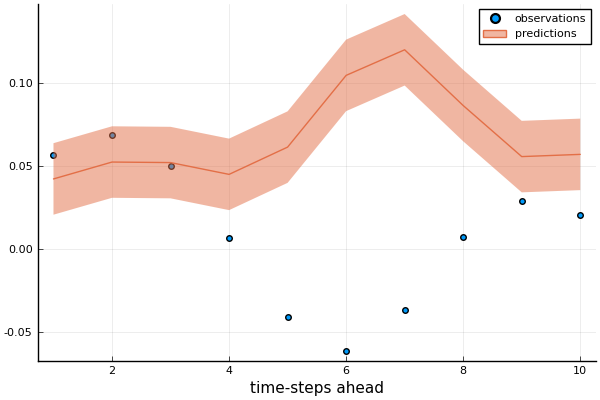

In [157]:
# Pick a time-point and visualize forecasting
t = 9000

# Mean and std dev of predictions
xpred_rw_mean = params_xpred_rw[1][1,t,2:TT+1]
xpred_rw_std = sqrt.(inv.(params_xpred_rw[2][1,1,t,2:TT+1])) 


scatter(output_[t+1:t+TT], label="observations", xlabel="time-steps ahead")
plot!(xpred_rw_mean, ribbon=[xpred_rw_std, xpred_rw_std], label="predictions")

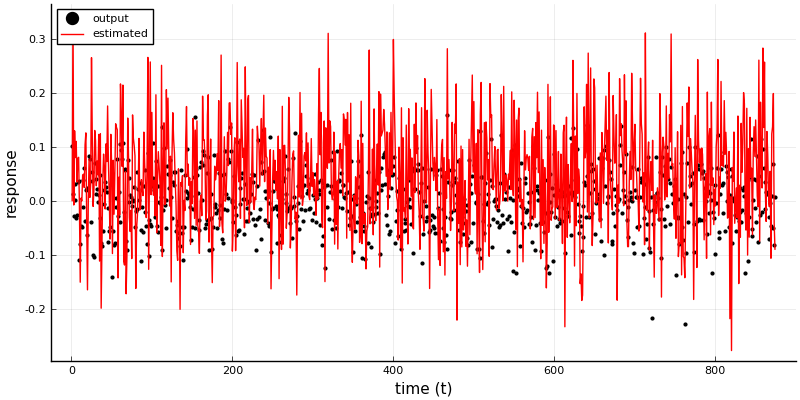

In [159]:
# Extract mean of state marginals
estimated_states_rw = params_xpred_rw[1][1,:,9]

# Plot every n-th time-point to avoid figure size exploding
n = 100

p3 = Plots.scatter(output_[1:n:end], color="black", label="output", markersize=2, size=(800,400), xlabel="time (t)", ylabel="response", legend=:topleft)
Plots.plot!(estimated_states_rw[1:n:end], color="red", linewidth=1, label="estimated")

## Visualize performance results

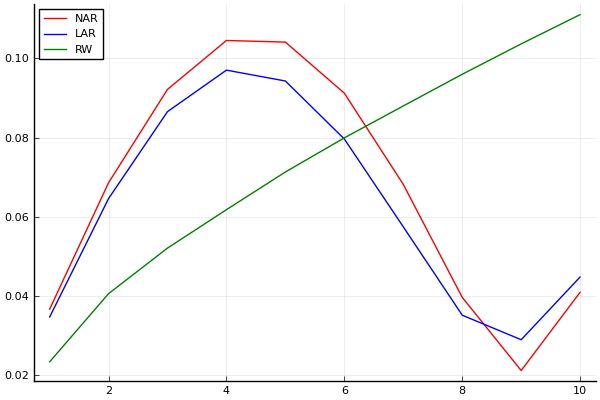

In [217]:
RMSE_rw = zeros(TT,)
RMSE_lar = zeros(TT,)
RMSE_nar = zeros(TT,)

ix = 20000:67390

for tt = 1:TT

    # Compute RMSE for each step ahead
    RMSE_rw[tt] = sqrt.(mean((params_xpred_rw[1][1,ix,1+tt] .- output_[ix]).^2))
    RMSE_lar[tt] = sqrt.(mean((params_xpred_lar[1][1,ix,1+tt] .- output_[ix]).^2))
    RMSE_nar[tt] = sqrt.(mean((params_xpred_nar[1][1,ix,1+tt] .- output_[ix]).^2))
    
end

p110 = plot(1:TT, RMSE_nar, color="red", label="NAR", size=(600,400))
plot!(1:TT, RMSE_lar, color="blue", label="LAR", size=(600,400))
plot!(1:TT, RMSE_rw, color="green", label="RW", size=(600,400))

In [162]:
savefig(p110, "viz/RMSE_comparison.png")

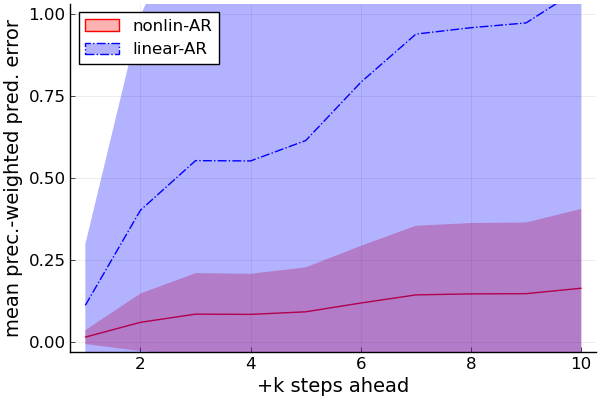

In [306]:
ix = 10:87390

mpwerr_lar = mean(pred_pwerr_lar[ix,:], dims=1)' 
spwerr_lar = sqrt.(var(pred_pwerr_lar[ix,:], dims=1)')
mpwerr_nar = mean(pred_pwerr_nar[ix,:], dims=1)' 
spwerr_nar = sqrt.(var(pred_pwerr_nar[ix,:], dims=1)')

# p110 = plot(1:TT, mpwerr_nar, color="red", label="nonlin-AR")
plot(1:TT, mpwerr_nar, ribbon=[spwerr_nar, spwerr_nar], fillalpha=0.3, color="red", label="nonlin-AR")
# plot!(1:TT, mpwerr_lar, color="blue", label="linear-AR", linestyle=:dashdot)
plot!(1:TT, mpwerr_lar, ribbon=[spwerr_lar, spwerr_lar], fillalpha=0.3, label="linear-AR", linestyle=:dashdot, color="blue", size=(600,400), ylim=[0., 1.], legend=:topleft, tickfontsize=12, xlabel="+k steps ahead", ylabel="mean prec.-weighted pred. error", legendfontsize=12, guidefontsize=14)
# plot!(1:TT, mpwerr_rw, color="green", label="RW", size=(600,400), ylim=[0., 1.], legend=:topleft)

In [307]:
savefig(p110, "viz/mpwerr_comparison.png")
savefig(p110, "viz/mpwerr_comparison.pdf")

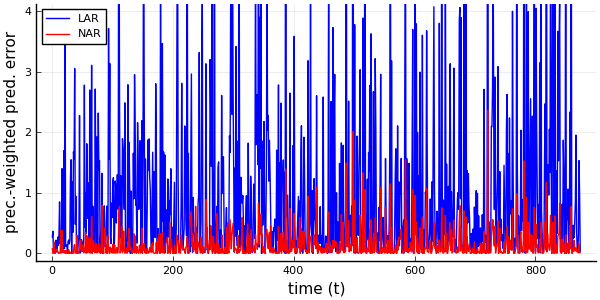

In [244]:
# Select subsampling
ss = 100

# Select a number of time-steps ahead
tt = 10

# Index performance metrics
pwerr_rw_tt = pred_pwerr_rw[10:ss:end,tt]
pwerr_lar_tt = pred_pwerr_lar[10:ss:end,tt]
pwerr_nar_tt = pred_pwerr_nar[10:ss:end,tt]

# Plot mean difference for all time
# plot(pwerr_rw_tt, color="green", label="RW", markersize=2, size=(600,400), xlabel="time (t)", ylabel="precision-weighted prediction error")
plot(pwerr_lar_tt, color="blue", label="LAR", markersize=2, size=(600,300), xlabel="time (t)", ylabel="prec.-weighted pred. error")
plot!(pwerr_nar_tt, color="red", label="NAR", markersize=2, size=(600,300), ylim=[0., 4.], legend=:topleft)

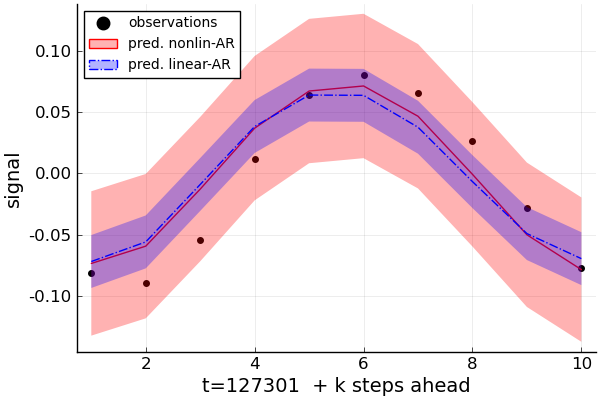

In [299]:
# Pick a time-point and visualize forecasting
t = 87200

xticks = [string(t)*"+1", string(t)*"+2"]

# Mean and std dev of predictions
xpred_nar_mean = params_xpred_nar[1][1,t,2:TT+1]
xpred_nar_std = sqrt.(inv.(params_xpred_nar[2][1,1,t,2:TT+1])) 
xpred_lar_mean = params_xpred_lar[1][1,t,2:TT+1]
xpred_lar_std = sqrt.(inv.(params_xpred_lar[2][1,1,t,2:TT+1])) 


p224 = scatter(output_[t+1:t+TT], label="observations", color="black", xlabel="t="*string(t+40101)*"  + k steps ahead")
plot!(xpred_nar_mean, ribbon=[xpred_nar_std, xpred_nar_std], fillalpha=0.3, color="red", label="pred. nonlin-AR")
plot!(xpred_lar_mean, ribbon=[xpred_lar_std, xpred_lar_std], fillalpha=0.3, color="blue", linestyle=:dashdot, label="pred. linear-AR", size=(600,400), tickfontsize=12, legendfontsize=10, legend=:topleft, ylabel="signal", guidefontsize=14)

In [303]:
savefig(p224, "viz/example-forecast-comparison.png")
savefig(p224, "viz/example-forecast-comparison.pdf")